# 20180813 세미나
201333360 진명훈

#### library 호출 및 초기값 setting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False


In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1. XGBoosting + Bagging

### 일전에 ensemble에서 설명한 moons데이터 load

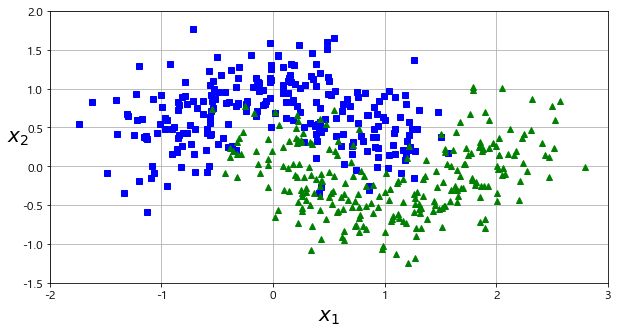

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 500, noise = 0.3, random_state = 42)
fig = plt.figure()
fig.set_size_inches((10,5))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

plt.axis([-2,3,-1.5,2])
plt.grid(True, which='both')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.show()

### train, test를 8:2로 분할

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### 단일 모델 및 Voting Classifier 구축

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
dct_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
gnb_clf = GaussianNB()
knn_clf = KNeighborsClassifier(n_neighbors=31)
svm_clf = SVC(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

voting_clf_1 = VotingClassifier(
    estimators=[("lr", log_clf),("dt", dct_clf),("nb", gnb_clf),
               ("knn", knn_clf),("svm", svm_clf),("rf", rf_clf)],
    voting="hard")
svm_clf2 = SVC(random_state=42, probability=True)
voting_clf_2 = VotingClassifier(
    estimators=[("lr", log_clf),("svm", svm_clf2),("rf", rf_clf)],
    voting="soft")

voting_clf_1.fit(X_train, y_train)
voting_clf_2.fit(X_train, y_train)

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from sklearn.metrics import accuracy_score
classifier_set = [log_clf, dct_clf, gnb_clf, knn_clf, \
                  svm_clf, rf_clf, voting_clf_1, voting_clf_2]
for clf in classifier_set:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.896
GaussianNB 0.856
KNeighborsClassifier 0.904
SVC 0.888
RandomForestClassifier 0.872
VotingClassifier 0.896
VotingClassifier 0.912


### XGBoost 호출, 예측 실시

In [13]:
import xgboost
clf = xgboost.XGBClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# val_error = mean_squared_error(y_test, y_pred)
# print("검증 MSE:", val_error)

In [8]:
y_pred

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [9]:
y_test

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [12]:
sum(y_pred == y_test) / len(y_test)

0.896

### XGBoost + Grid_Search

In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {"max_depth" : [3,4,5,6,7,8,9,10],
     "learning_rate" : [0.01,0.03,0.05,0.07,0.09,0.1,0.12,0.14,0.16,0.18,0.2],
     "n_estimators" : [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31],
     "booster" : ["gbtree", "gblinear", "dart"],
     "gamma" : [0.01,0.05,0.1,0.3,0.5,0.7,0.9,1.1],
    }
]
clf = xgboost.XGBClassifier(random_state=42)
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='logloss', verbose=True, 
        early_stopping_rounds=2)
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

[0]	validation_0-logloss:0.631656	validation_1-logloss:0.632962
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 2 rounds.
[1]	validation_0-logloss:0.580969	validation_1-logloss:0.583439
[2]	validation_0-logloss:0.538471	validation_1-logloss:0.5412
[3]	validation_0-logloss:0.502534	validation_1-logloss:0.505538
[4]	validation_0-logloss:0.470692	validation_1-logloss:0.475655
[5]	validation_0-logloss:0.443442	validation_1-logloss:0.450297
[6]	validation_0-logloss:0.420281	validation_1-logloss:0.427023
[7]	validation_0-logloss:0.399456	validation_1-logloss:0.406678
[8]	validation_0-logloss:0.381446	validation_1-logloss:0.389708
[9]	validation_0-logloss:0.365664	validation_1-logloss:0.37391
[10]	validation_0-logloss:0.35134	validation_1-logloss:0.360137
[11]	validation_0-logloss:0.338837	validation_1-logloss:0.349324
[12]	validation_0-logloss:0.324931	validation_1-logloss:0.339494
[13]	

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2], 'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], 'booster': ['gbtree', 'gblinear', 'dart'], 'gamma': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
grid_search.best_params_

{'booster': 'gbtree',
 'gamma': 0.1,
 'learning_rate': 0.2,
 'max_depth': 4,
 'n_estimators': 17}

### best_estimator로 예측 실시

In [38]:
best = xgboost.XGBClassifier(random_state=42, 
                            booster = 'gbtree',
                            gamma = 0.1,
                            learning_rate = 0.2,
                            max_depth = 4,
                            n_estimators = 17)
best.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='logloss', verbose=True, 
        early_stopping_rounds=2)
y_pred = best.predict(X_test)

[0]	validation_0-logloss:0.571993	validation_1-logloss:0.575688
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 2 rounds.
[1]	validation_0-logloss:0.487485	validation_1-logloss:0.49526
[2]	validation_0-logloss:0.426611	validation_1-logloss:0.437587
[3]	validation_0-logloss:0.379777	validation_1-logloss:0.394632
[4]	validation_0-logloss:0.342321	validation_1-logloss:0.362712
[5]	validation_0-logloss:0.311389	validation_1-logloss:0.335174
[6]	validation_0-logloss:0.286475	validation_1-logloss:0.3112
[7]	validation_0-logloss:0.265478	validation_1-logloss:0.293854
[8]	validation_0-logloss:0.246661	validation_1-logloss:0.28237
[9]	validation_0-logloss:0.230042	validation_1-logloss:0.270838
[10]	validation_0-logloss:0.216952	validation_1-logloss:0.261813
[11]	validation_0-logloss:0.203627	validation_1-logloss:0.253792
[12]	validation_0-logloss:0.193043	validation_1-logloss:0.249577
[13]	

In [39]:
sum(y_pred == y_test) / len(y_test)

0.904

### XGBoost + Bagging

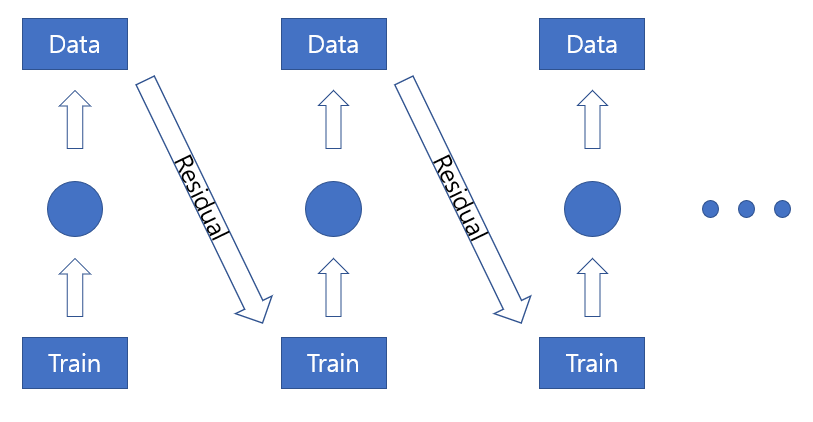

In [87]:
from PIL import Image
Image.open("fig120180813.png")

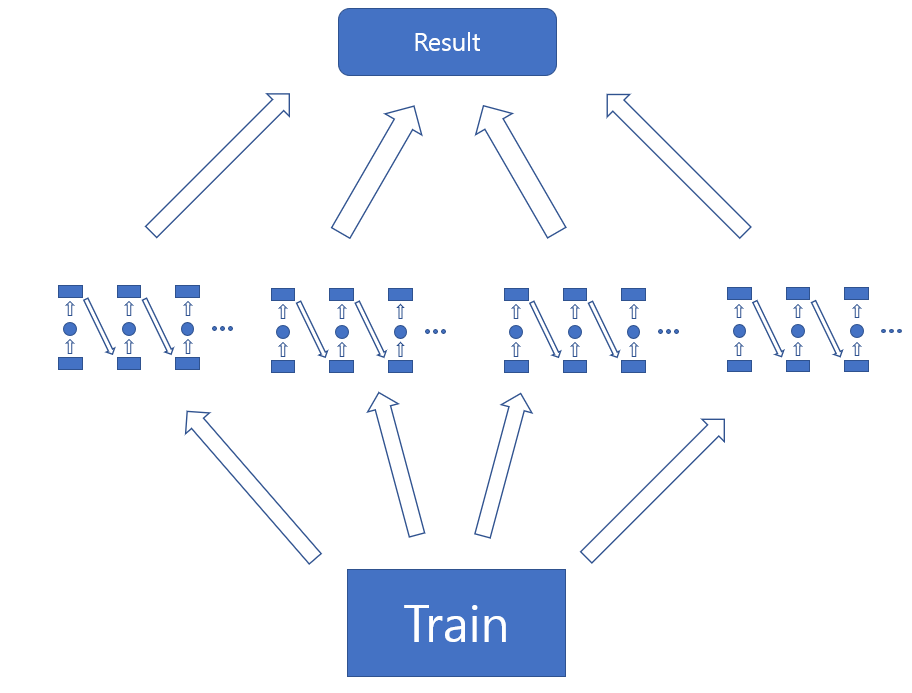

In [88]:
Image.open("fig220180813.png")

In [43]:
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

bag_clf = BaggingClassifier(
        XGBClassifier(), n_estimators = 500,
        max_samples = 100, bootstrap = True, n_jobs = -1)
bag_clf.fit(X_train, y_train)
bag_y_pred = bag_clf.predict(X_test)

In [45]:
sum(bag_y_pred == y_test) / len(y_test)

0.912

### 시각화

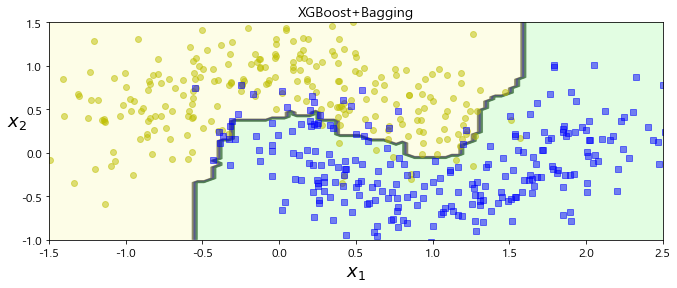

In [46]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

li = [log_clf, dct_clf, gnb_clf, knn_clf,svm_clf, rf_clf, voting_clf_1, voting_clf_2]
today = [clf,best, bag_clf]
    
plt.figure(figsize=(11,4))
#plt.subplot(121)
plot_decision_boundary(bag_clf, X, y)
plt.title("XGBoost+Bagging", fontsize=14)
#plt.subplot(122)
#plot_decision_boundary(bag_clf, X, y)
#plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.show()

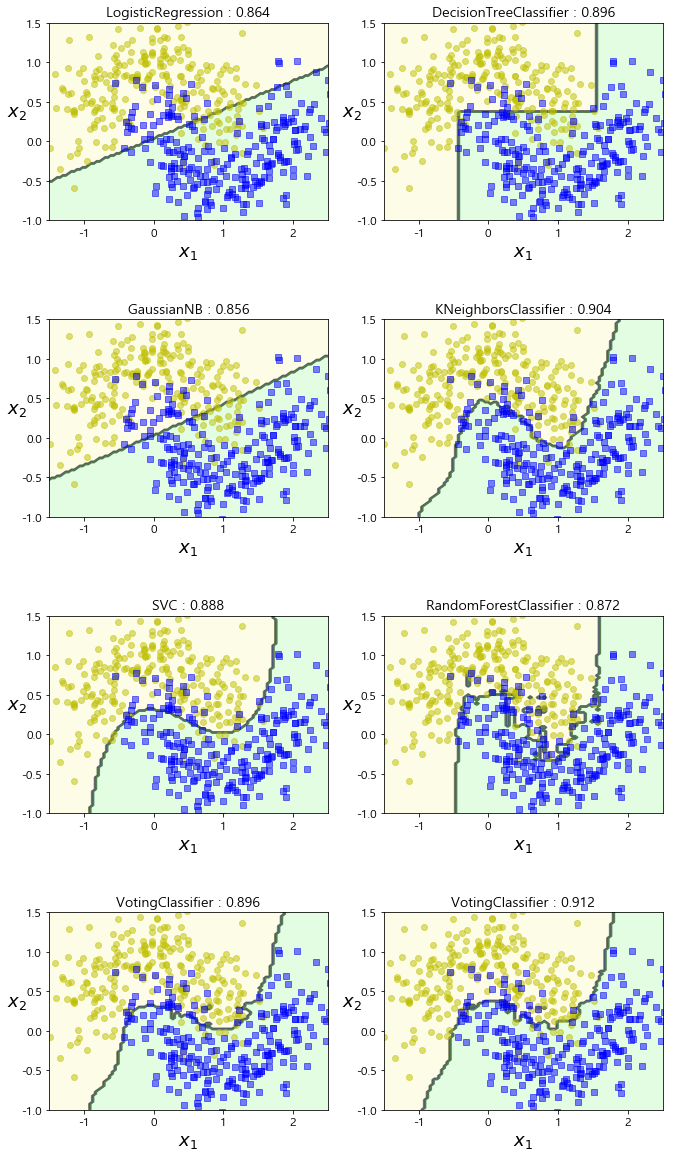

In [75]:
from sklearn.metrics import accuracy_score
plt.figure(figsize=(11,20))
i = 0
for clf in li:
    i+=1
    plt.subplot(420+i)
    plot_decision_boundary(clf, X, y)
    pred = clf.predict(X_test)
    plt.title("{} : {}".format(str(clf).split("(")[0], accuracy_score(y_test,pred)), fontsize=14)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.show()

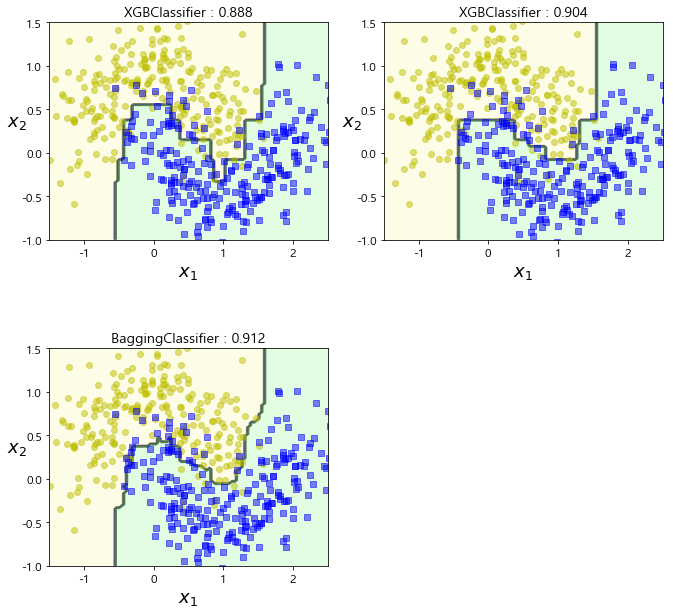

In [82]:
plt.figure(figsize=(11,10))
i = 0
for t in today:
    i+=1
    plt.subplot(220+i)
    plot_decision_boundary(t, X, y)
    pred = t.predict(X_test)
    plt.title("{} : {}".format(str(t).split("(")[0], accuracy_score(y_test,pred)), fontsize=14)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.show()

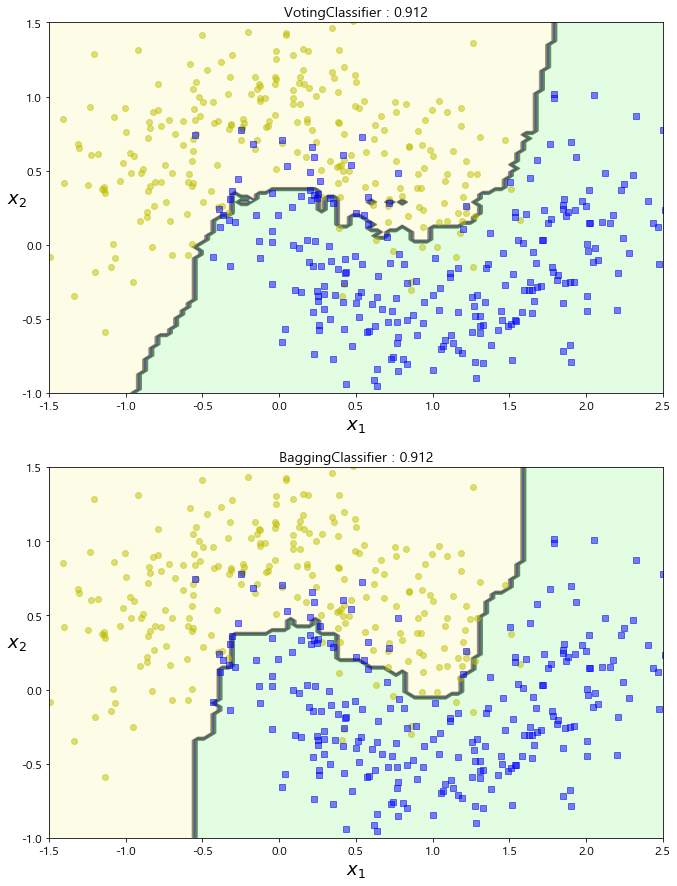

In [84]:
plt.figure(figsize=(11,15))
i = 0
for t in [voting_clf_2, bag_clf]:
    i+=1
    plt.subplot(210+i)
    plot_decision_boundary(t, X, y)
    pred = t.predict(X_test)
    plt.title("{} : {}".format(str(t).split("(")[0], accuracy_score(y_test,pred)), fontsize=14)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
plt.show()

# 2. Crawling

### Infomax_close

In [89]:
close = pd.read_csv("./data/infomax_data/new/single/close.csv", encoding = "cp949", low_memory=False)
close = close.loc[:1371]
close.head()

,일자,AK홀딩스,BGF,BGF리테일,BNK금융지주,CJ,CJ CGV,CJ대한통운,CJ제일제당,DB손해보험,...,현대중공업,현대중공업지주,현대차,현대해상,현대홈쇼핑,호텔신라,효성,효성중공업,후성,휴켐스
0,2013-01-02,22250,NaN,NaN,13450,124500,32250,103500,362000,44450,...,248500,NaN,216000,32000,122500,43500,74300,NaN,4965,25600
1,2013-01-03,23000,NaN,NaN,13750,123500,32100,102000,369000,43800,...,248500,NaN,206000,31750,120500,41800,74800,NaN,4955,25500
2,2013-01-04,23700,NaN,NaN,13900,128000,32300,107500,375000,43600,...,243500,NaN,206000,32650,123500,41550,74700,NaN,4980,25050
3,2013-01-07,23800,NaN,NaN,14000,127000,32750,107500,368000,44500,...,241500,NaN,208500,33150,125500,44000,73400,NaN,5080,25650
4,2013-01-08,23700,NaN,NaN,14100,122500,32650,113000,358000,42800,...,237000,NaN,210000,32100,125000,43750,71100,NaN,5130,26250


### 한국거래소 KOSPI200 종목 코드

In [90]:
kospi200 = pd.read_csv("./data/data.csv", encoding="cp949")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)
kospi200.head()

,종목코드,종목명
0,006840,AK홀딩스
1,027410,BGF
2,282330,BGF리테일
3,138930,BNK금융지주
4,001040,CJ


In [91]:
code_dict = {
    i : j for i, j in zip(kospi200["종목명"], kospi200["종목코드"])
}

In [92]:
code_dict["삼성전자"]

'005930'

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-07-11 2:1
2016-05-25 5:1


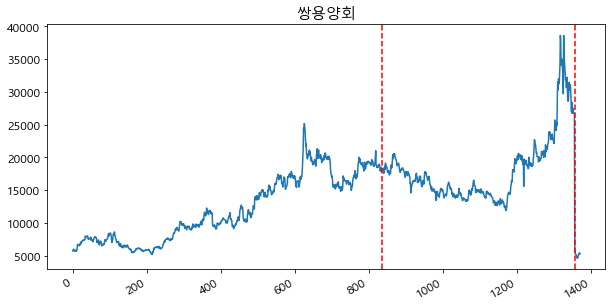

2018-05-08 5:1


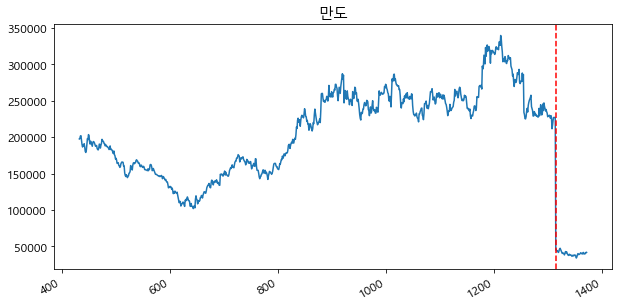

2018-05-04 50:1


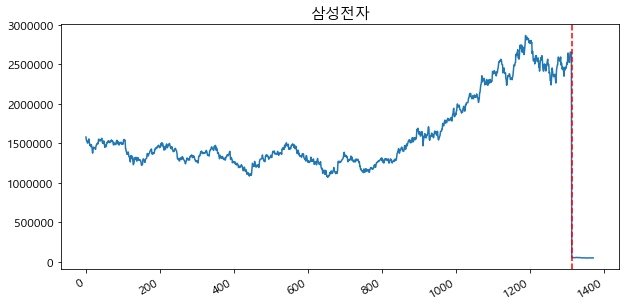

2018-04-30 10:1
2016-12-28 1.2:1
2015-12-29 1.1:1
2014-12-29 1.1:1
2013-12-30 1.05:1


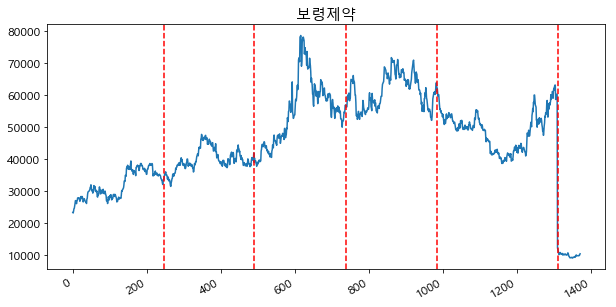

2018-03-07 1:2.5
2016-09-30 2:1


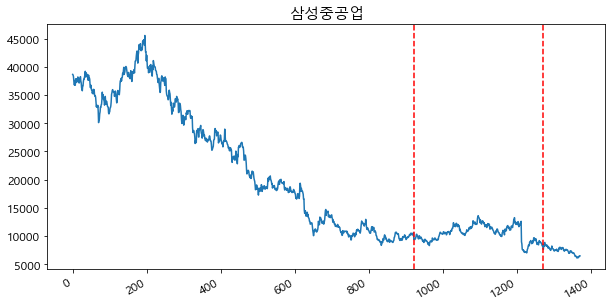

2018-02-05 1.071:1


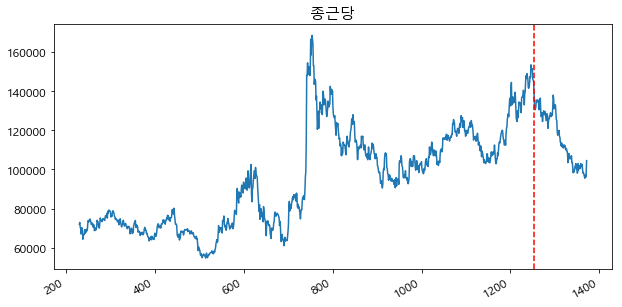

2018-01-31 2:1
2017-05-10 1.206:1


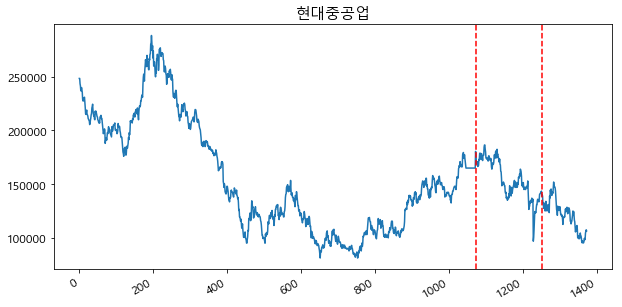

2018-01-11 1.034:1


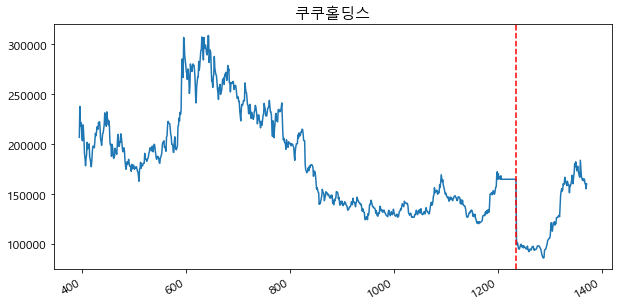

2018-01-05 1:4
2015-10-15 1.017:1


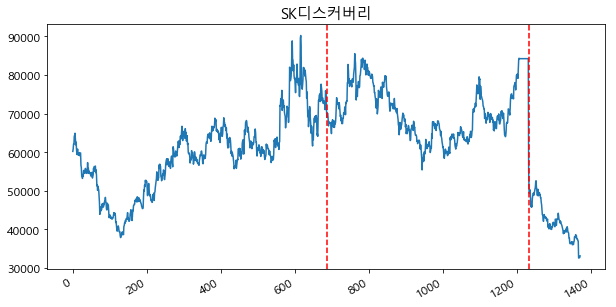

2017-12-27 1.02:1
2016-12-28 1.05:1
2015-12-29 1.03:1
2014-12-29 1.05:1
2013-12-27 1.03:1


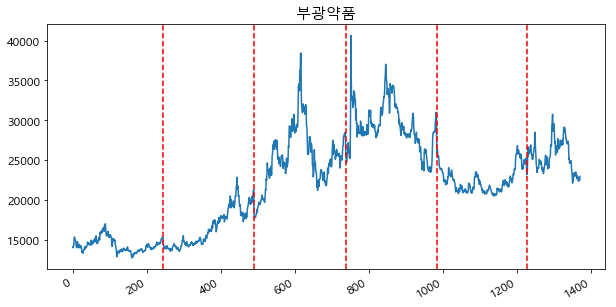

2017-12-27 1.02:1
2016-12-28 1.05:1
2015-12-29 1.03:1
2014-12-29 1.05:1
2013-12-27 1.05:1
2013-03-22 1:2


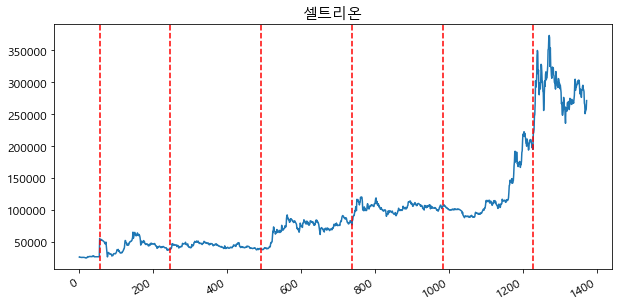

2017-12-27 1.02:1
2017-02-15 1.07:1
2015-12-29 1.02:1
2014-12-29 1.05:1
2014-02-10 1.104:1
2013-12-16 1.052:1


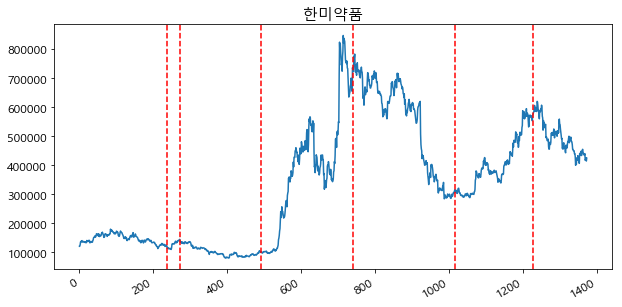

2017-12-27 1.05:1
2017-02-15 1.062:1
2015-12-29 1.005:1
2014-12-29 1.03:1
2013-12-30 1.1:1


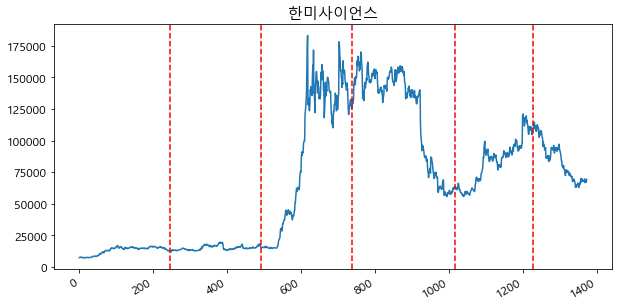

2017-12-27 1.02:1
2015-12-29 1.05:1
2014-12-29 1.05:1
2013-12-27 1.05:1


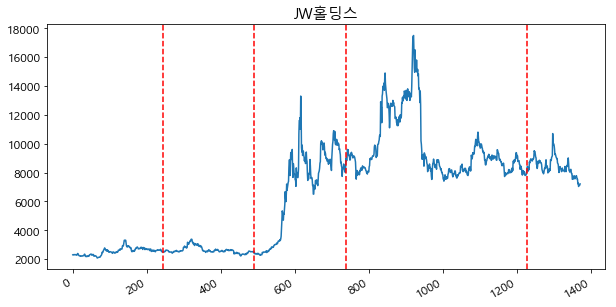

2017-12-27 1.015:1
2016-12-28 1.01:1
2015-12-29 1.03:1
2014-12-29 1.2:1
2013-12-27 1.06:1


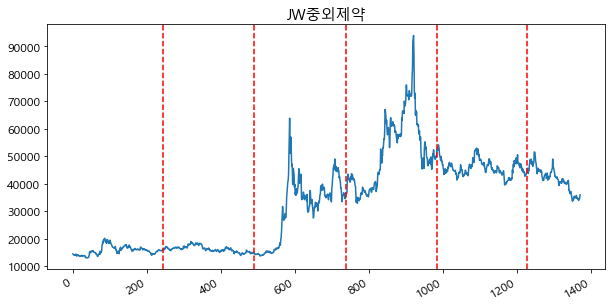

2017-12-27 1.5:1
2014-12-29 1.05:1


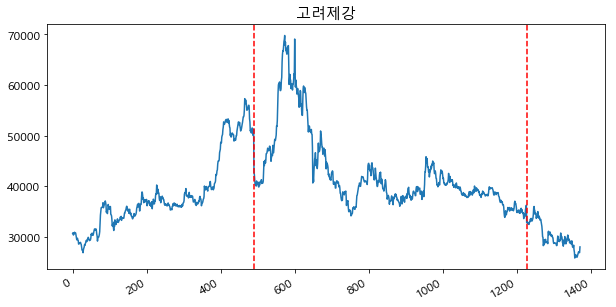

2017-12-27 3:1
2016-12-28 1.085:1


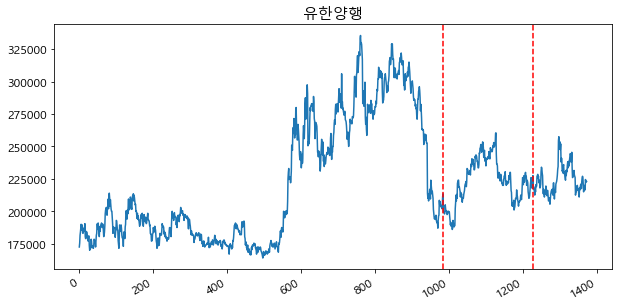

2017-12-08 2:1
2016-11-23 1.5:1


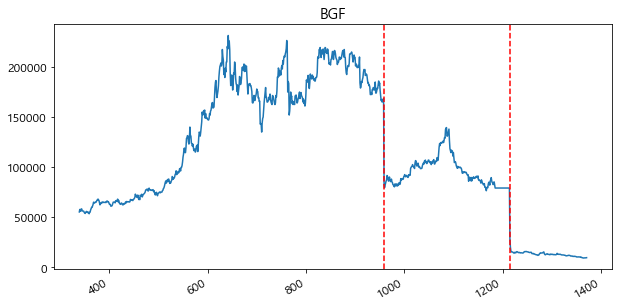

2017-10-30 1.76:1


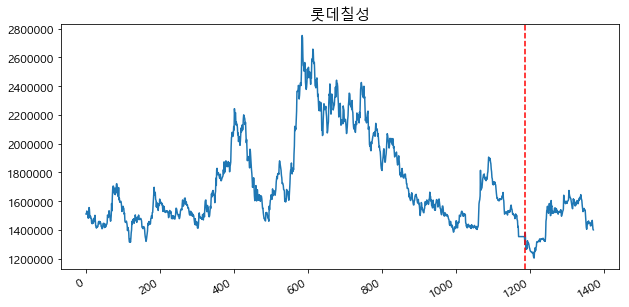

2017-10-30 1:1.21
2016-05-17 1.172:1


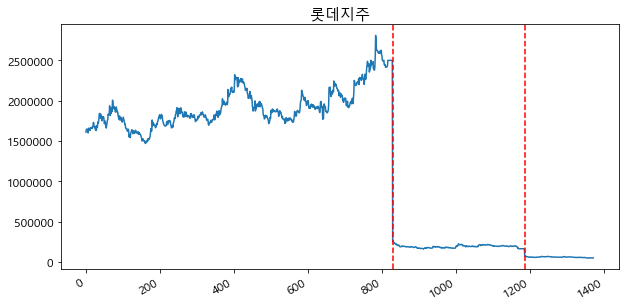

2017-10-30 1:1.12


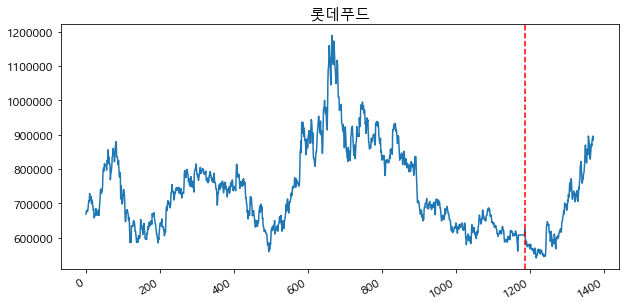

2017-10-30 1.322:1


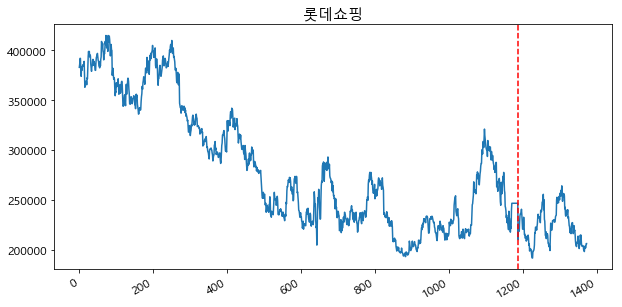

2017-07-24 1.06:1


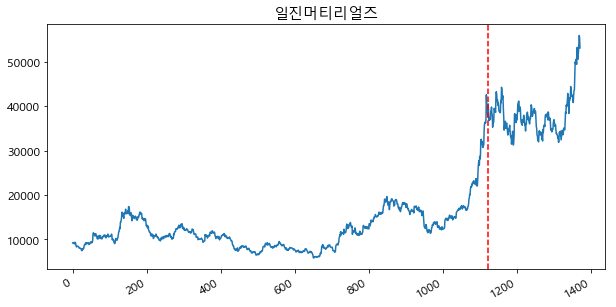

2017-07-07 2:1


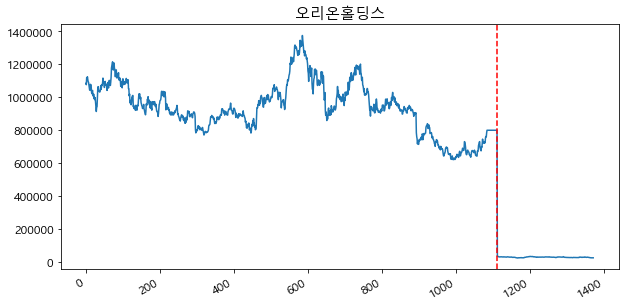

2017-01-31 2:1


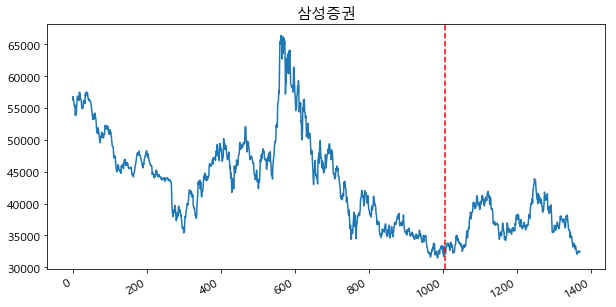

2017-01-24 50:1
2015-02-05 1.5:1
2013-09-16 1.033:1


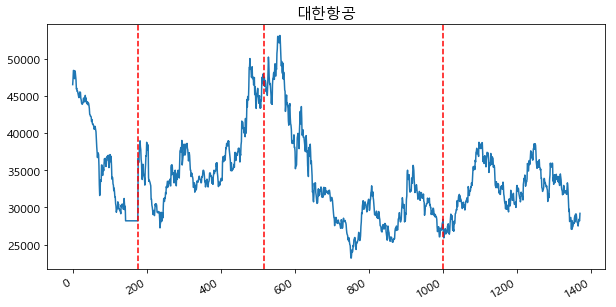

2017-01-16 1:6


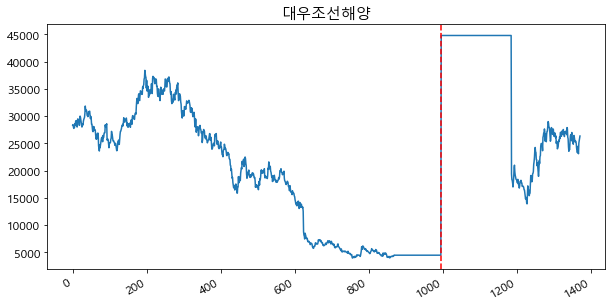

2016-11-09 1.5:1


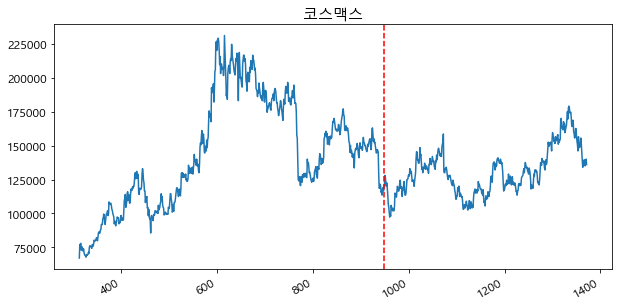

2016-02-16 1:10


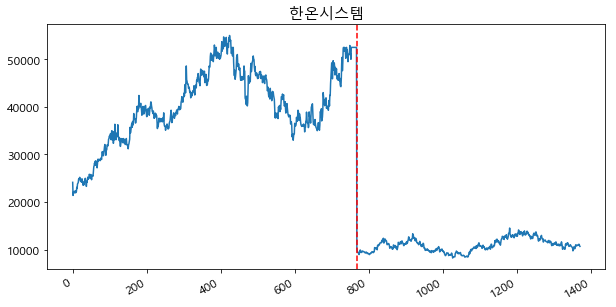

2015-12-29 1.034:1
2014-12-29 1.035:1
2013-12-27 1.03:1


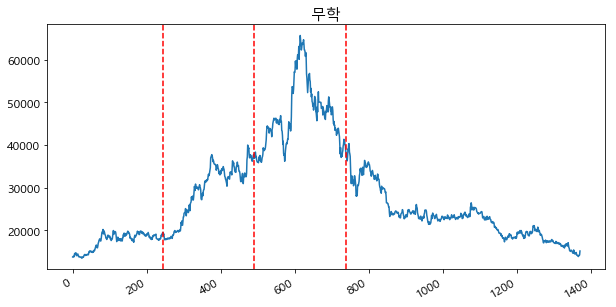

2015-12-29 1.107:1


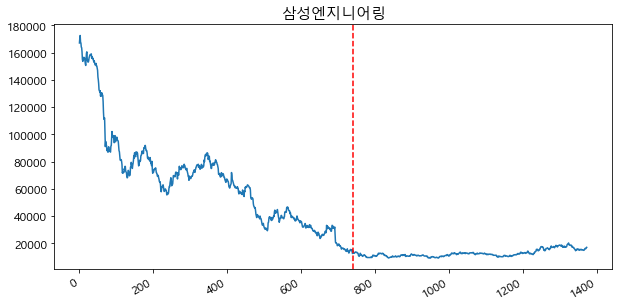

2015-12-04 2:1
2014-05-28 1:5


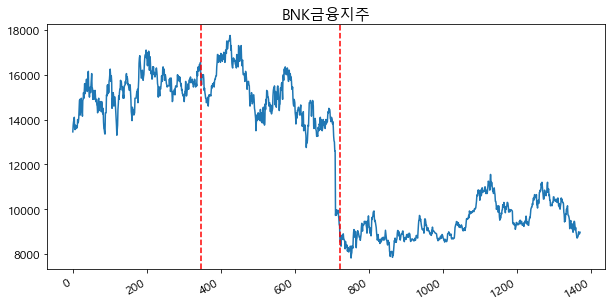

2015-07-31 1.555:1


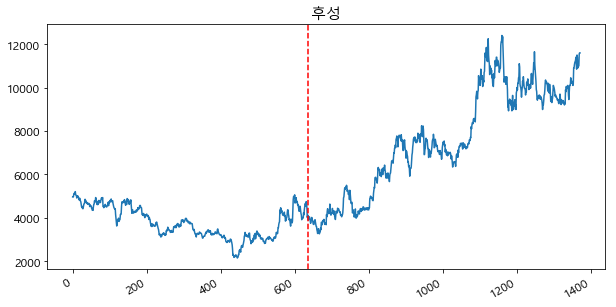

2015-07-29 1.04:1


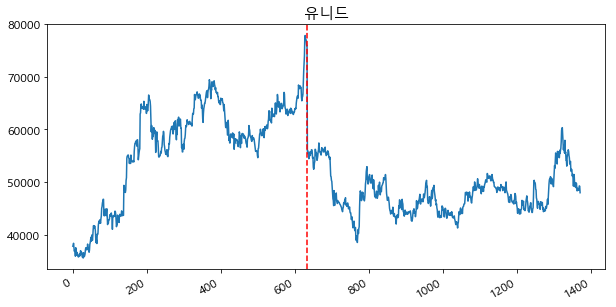

2015-07-27 1:2.91
2014-01-24 1:36.68


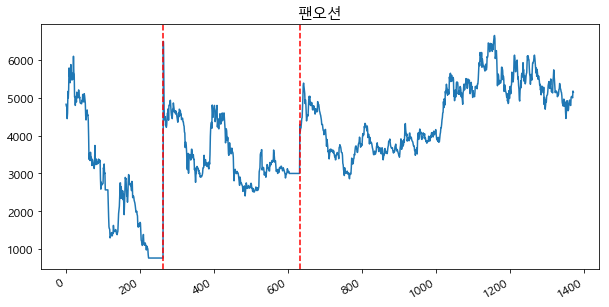

2015-07-16 1:8


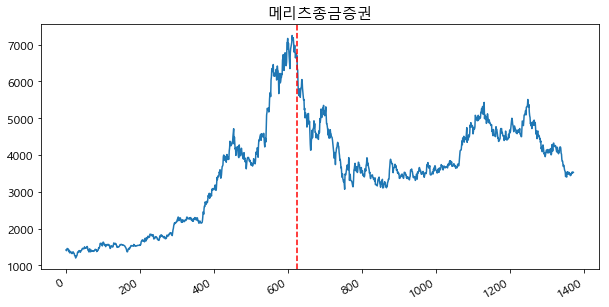

2015-06-09 10:1
2014-01-16 1.3:1


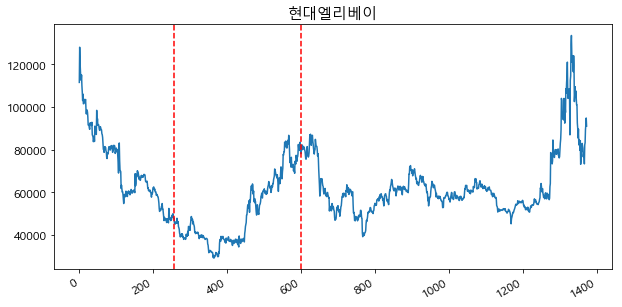

2015-05-08 10:1


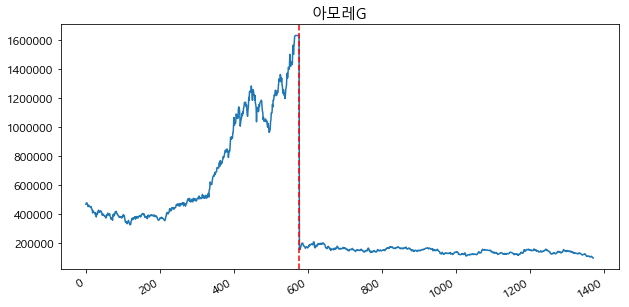

2015-05-08 10:1


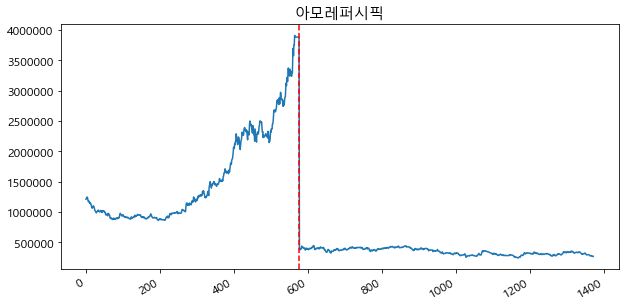

2014-10-06 1.226:1


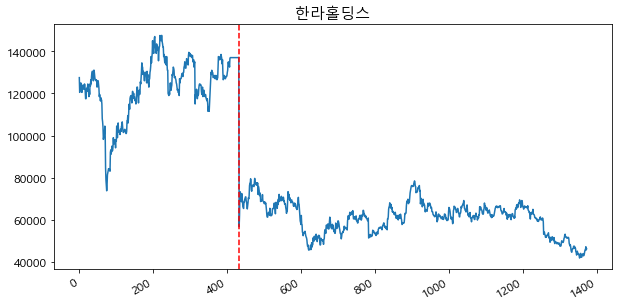

2014-07-07 1:5


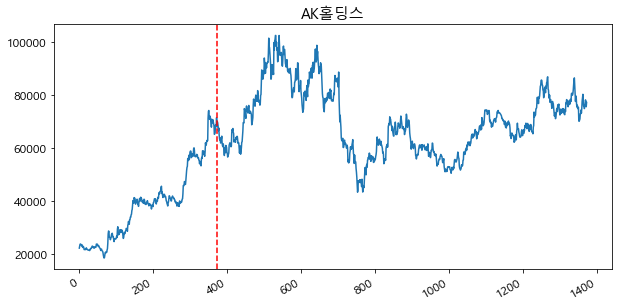

2014-07-02 1.051:1
2013-02-01 1.086:1


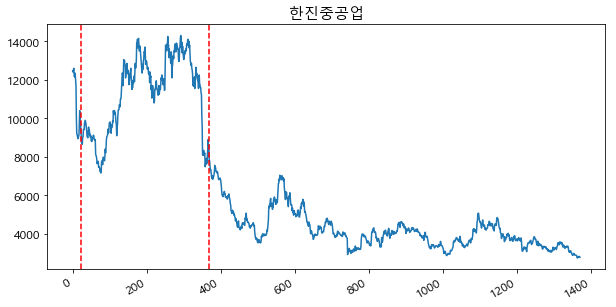

2014-06-20 1.043:1


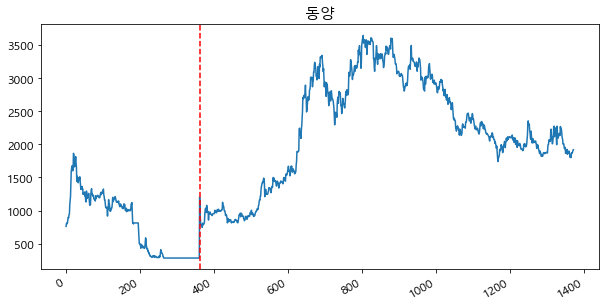

2014-05-16 1:5


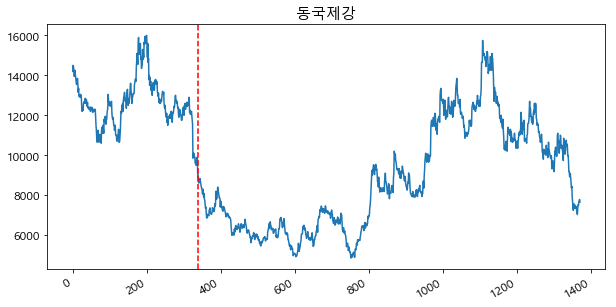

2014-04-23 1.356:1


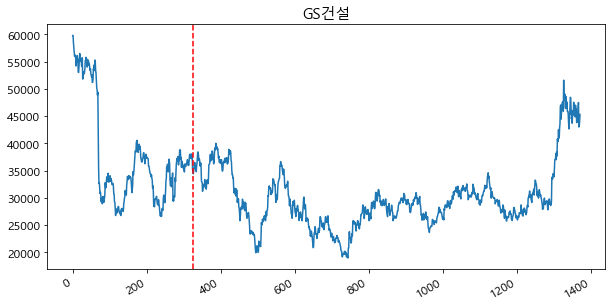

2013-11-27 1.057:1


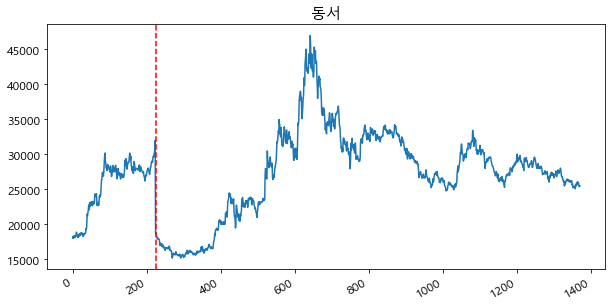

2013-09-05 2.5:1


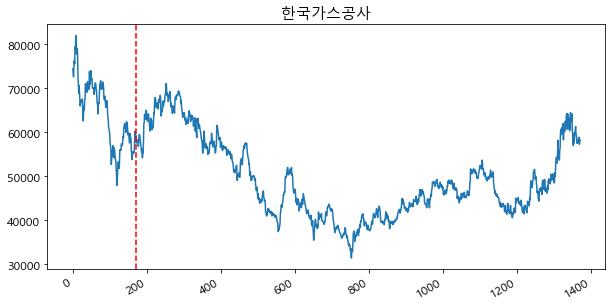

2013-08-29 1.187:1


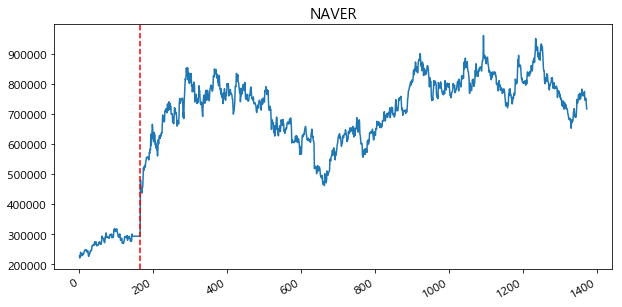

2013-06-07 1.4:1
2013-04-19 1.017:1


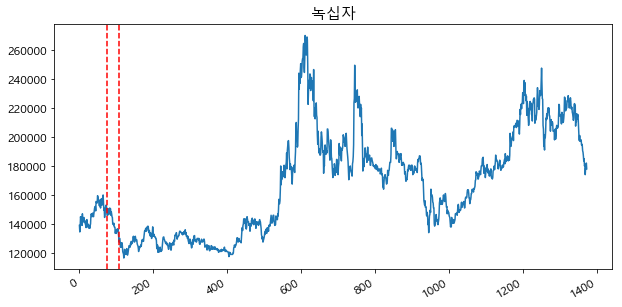

2013-04-08 1:2.69


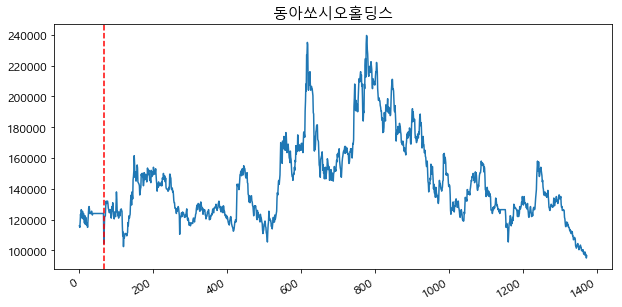

2013-01-28 1:10


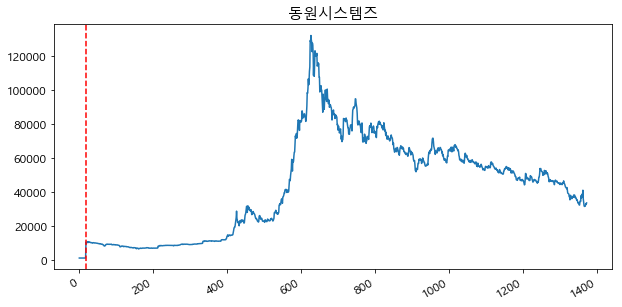

In [94]:
c_li = {}
li_c = {}
v_li = {}
li_v = {}
for i in range(len(kospi200)):
    c_li[close.columns[1:][i]] = kospi200["종목코드"][i]
    li_c[kospi200["종목코드"][i]] = close.columns[1:][i]
    v_li[close.columns[1:][i]] = "XKRX:" + kospi200["종목코드"][i]
    li_v["XKRX:" + kospi200["종목코드"][i]] = close.columns[1:][i]

ss = pd.read_csv("./data/stock_split_2.csv", encoding="cp949")
ss = ss[ss.columns[:3]]
ss["Split date"] = ss["Split date"].fillna(method="ffill")
ss["Company"] = [i[2] for i in list(map(lambda x : x.split("?"), ss["Company"]))]
ss["Company"] = [i[1:7]for i in ss["Company"]]
ss.columns = ["split_date", "code", "split_ratio"]
ss200 = ss.loc[[i in list(li_c.keys()) for i in ss["code"]]]
ss200["company"] = ss200["code"].replace(li_c)

import sys
mod = sys.modules[__name__]

di = {}

for i in ss200.company.unique():
    temp = ss200[ss200.company == i].split_date
    time = ss200[ss200.company == i].split_date.iloc[0]
    ratio = ss200[ss200.company == i].split_ratio.iloc[0]
    indexing = np.where(close["일자"] == time)[0][0]
    close[i].plot(subplots=True, figsize=(10,5))
    plt.axvline(x=indexing, color='r',linestyle='--')
    if len(temp)>1:
        time_li = []
        ratio_li = []
        for j in range(1,len(temp)):
            setattr(mod, "time{}".format(j), ss200[ss200.company == i].split_date.iloc[j])
            setattr(mod, "ratio{}".format(j), ss200[ss200.company == i].split_ratio.iloc[j])
            indexing = np.where(close["일자"] == getattr(mod, "time{}".format(j)))[0][0]
            plt.axvline(x=indexing, color='r',linestyle='--')
            time_li.append(getattr(mod, "time{}".format(j)))
            ratio_li.append(getattr(mod, "ratio{}".format(j)))
        print(time, ratio)
        for m, n in zip(time_li, ratio_li):
            print(m, n)
        time_li.append(time)
        di[i] = time_li
    else:
        print(time, ratio)
        di[i] = time
    plt.title(i, fontsize=15)
    plt.show()

Text(0.5,1,'팬오션')

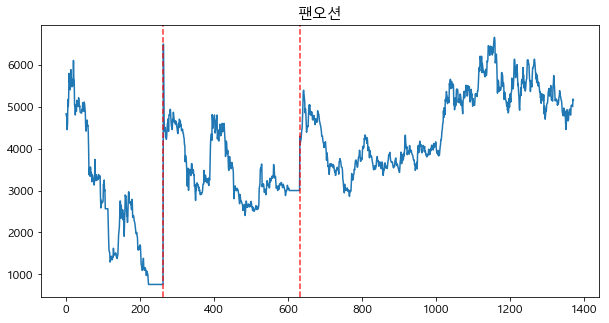

In [97]:
i = "팬오션"
time = di[i]
close[i].plot(figsize=(10,5))
if len(time)>9:
    indexing = np.where(close["일자"] == time)[0][0]
    plt.axvline(x=indexing, color='r',linestyle='--', alpha=0.8)
else:
    for j in time:
        indexing = np.where(close["일자"] == j)[0][0]
        plt.axvline(x=indexing, color='r',linestyle='--', alpha=0.8)
plt.title(i, fontsize=15)

### 전처리를 시도하였으나 General하지 못하다고 판단

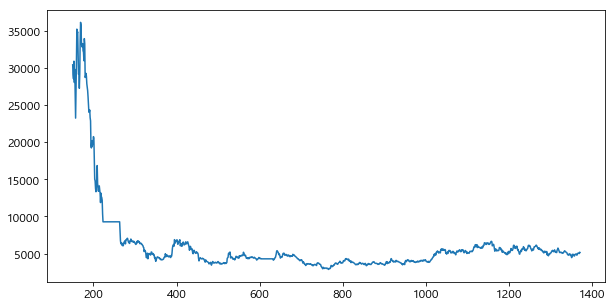

In [114]:
df = close.copy()
df.index = close.일자
plt.figure(figsize=(10,5))
test = df["팬오션"] = pd.concat(
    (df.loc[:"2014-01-23"]["팬오션"] * 8.515*1.43,
     df.loc["2014-01-24":"2015-07-26"]["팬오션"] * 1.43, 
     df.loc["2015-07-27":]["팬오션"]))
t = test.copy()
t.index = range(len(test))
plt.plot(t.iloc[150:])
plt.show()

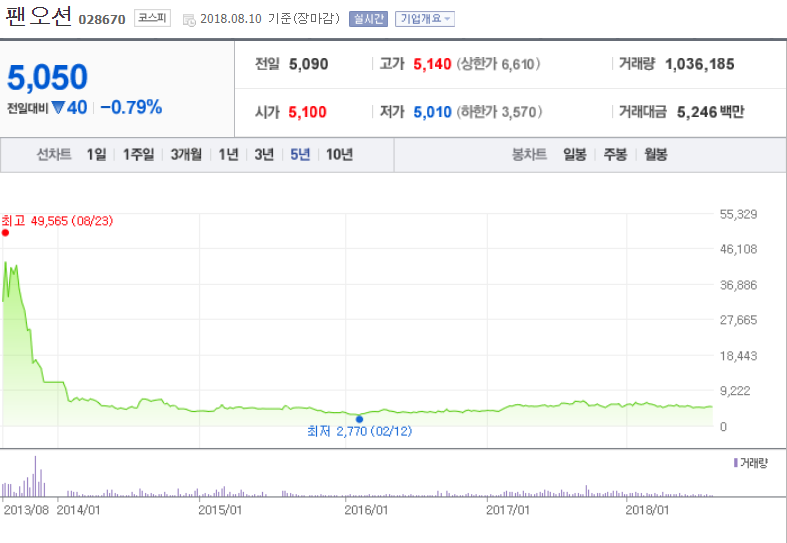

In [102]:
Image.open("팬오션.png")

### Crawling 실시

In [122]:
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2012,1,1)
end = datetime.datetime(2018,8,9)

In [128]:
li = ["XKRX:"+i for i in kospi200["종목코드"]]
raw_dict = {}
try:
    for i in li:
        raw_dict[i[5:]] = web.DataReader(i, "morningstar", start, end)
except Exception:
    print("Exception : Request Error!: 404 : Not Found!")

Exception : Request Error!: 404 : Not Found!


In [129]:
try:
    web.DataReader("KRX:005930", "robinhood", start, end, retry_count=10)
except KeyError:
    print("KeyError")

KeyError


In [131]:
from pandas_datareader.quandl import QuandlReader
ticker = "AAPL"
data = QuandlReader("WIKI/{}".format(ticker), start=start, end=end) 
df = data.read()
df.head()

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0


### Yahoo-Finance data load

In [132]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

samsung = fix_yahoo_finance.download("005930.KS", start="2012-01-01", end="2018-08-01")

[*********************100%***********************]  1 of 1 downloaded


In [133]:
samsung.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,21400.0,21600.0,21300.0,21600.0,21.233131,13151350
2012-01-03,21860.0,22100.0,21840.0,22100.0,21.724644,16927750
2012-01-04,22100.0,22200.0,21500.0,21600.0,21.233131,17103700
2012-01-05,21460.0,21580.0,21100.0,21100.0,20.741627,17298400
2012-01-06,21120.0,21320.0,20600.0,20800.0,20.446722,18816250


# 3. Base Line

In [134]:
import pickle

with open('raw_data_20180811.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [136]:
raw_data["005930"].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,21400.0,21600.0,21300.0,21600.0,21.233131,13151350
2012-01-03,21860.0,22100.0,21840.0,22100.0,21.724644,16927750
2012-01-04,22100.0,22200.0,21500.0,21600.0,21.233131,17103700
2012-01-05,21460.0,21580.0,21100.0,21100.0,20.741627,17298400
2012-01-06,21120.0,21320.0,20600.0,20800.0,20.446722,18816250


In [137]:
raw_data[code_dict["삼성전자"]].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,21400.0,21600.0,21300.0,21600.0,21.233131,13151350
2012-01-03,21860.0,22100.0,21840.0,22100.0,21.724644,16927750
2012-01-04,22100.0,22200.0,21500.0,21600.0,21.233131,17103700
2012-01-05,21460.0,21580.0,21100.0,21100.0,20.741627,17298400
2012-01-06,21120.0,21320.0,20600.0,20800.0,20.446722,18816250


In [138]:
def get_macd(df, short=12, long=26, t=9): 
    
    # 입력받은 값이 dataframe이라는 것을 정의해줌 
    df = pd.DataFrame(df) 
    
    # MACD 관련 수식 
    ma_12 = df.Close.ewm(span=12).mean() # 단기(12) EMA(지수이동평균) 
    ma_26 = df.Close.ewm(span=26).mean() # 장기(26) EMA 
    macd = ma_12 - ma_26 # MACD 
    macds = macd.ewm(span=9).mean() # Signal 
    macdo = macd - macds # Oscillator 
    
    df = df.assign(macd=macd, signal=macds, oscilator=macdo).dropna() 
    return df

# 출처: http://excelsior-cjh.tistory.com/110?category=975542 [EXCELSIOR]

In [139]:
for i in raw_data.keys():
    raw_data[i] = get_macd(raw_data[i])
    raw_data[i] = raw_data[i].assign(cond1 = raw_data[i]["macd"] > 0, cond2 = raw_data[i]["oscilator"] > 0)
    raw_data[i] = raw_data[i].assign(long_short = raw_data[i]["cond1"] & raw_data[i]["cond2"])
    raw_data[i].long_short = raw_data[i].long_short.replace({False:0,True:1})
    raw_data[i] = raw_data[i].assign(pct_change = raw_data[i].Close.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(Y = np.where(raw_data[i]["pct_change"].fillna(0)>=0, 1,0))
    for j in [10,15,20,25,40,60,100,120]:
        raw_data[i] = raw_data[i].assign(ma_10 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_15 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_20 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_25 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_40 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_60 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_100 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_120 = raw_data[i].Close.ewm(span = j).mean())

In [141]:
raw_data["005930"].head()

,Open,High,Low,Close,Adj Close,Volume,macd,signal,oscilator,cond1,...,pct_change,Y,ma_10,ma_15,ma_20,ma_25,ma_40,ma_60,ma_100,ma_120
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-02,21400.0,21600.0,21300.0,21600.0,21.233131,13151350,0.000000,0.000000,0.000000,False,...,0.000000,1,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000
2012-01-03,21860.0,22100.0,21840.0,22100.0,21.724644,16927750,11.217949,6.232194,4.985755,True,...,0.023148,1,21852.083333,21852.083333,21852.083333,21852.083333,21852.083333,21852.083333,21852.083333,21852.083333
2012-01-04,22100.0,22200.0,21500.0,21600.0,21.233131,17103700,-1.211077,3.181673,-4.392750,False,...,-0.022624,0,21766.651235,21766.651235,21766.651235,21766.651235,21766.651235,21766.651235,21766.651235,21766.651235
2012-01-05,21460.0,21580.0,21100.0,21100.0,20.741627,17298400,-24.886670,-6.326573,-18.560097,False,...,-0.023148,0,21595.798903,21595.798903,21595.798903,21595.798903,21595.798903,21595.798903,21595.798903,21595.798903
2012-01-06,21120.0,21320.0,20600.0,20800.0,20.446722,18816250,-49.165397,-19.070155,-30.095242,False,...,-0.014218,0,21431.289959,21431.289959,21431.289959,21431.289959,21431.289959,21431.289959,21431.289959,21431.289959


In [142]:
raw_data["005930"].Close.head()

Date
2012-01-02    21600.0
2012-01-03    22100.0
2012-01-04    21600.0
2012-01-05    21100.0
2012-01-06    20800.0
Name: Close, dtype: float64

In [143]:
raw_data["005930"].Close.pct_change().head()

Date
2012-01-02         NaN
2012-01-03    0.023148
2012-01-04   -0.022624
2012-01-05   -0.023148
2012-01-06   -0.014218
Name: Close, dtype: float64

In [144]:
np.where(raw_data["005930"]["pct_change"].fillna(0)>=0, 1,0)

array([1, 1, 0, ..., 0, 0, 1])

Text(0.5,1,'삼성전자')

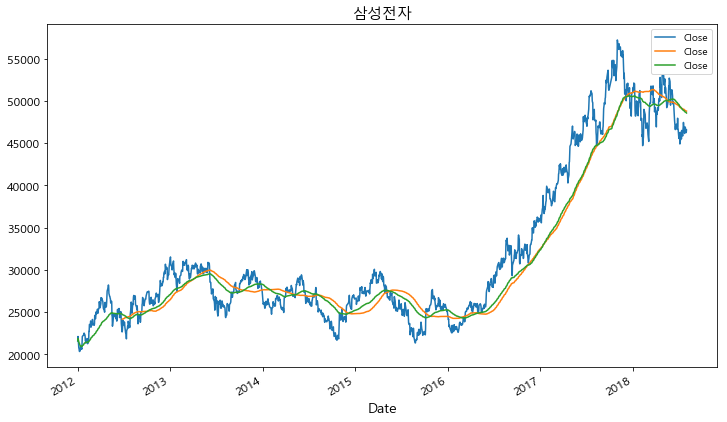

In [152]:
plt.figure(figsize=(12,7))
raw_data["005930"].Close.plot()
raw_data["005930"].Close.rolling(120).mean().plot()
raw_data["005930"].Close.ewm(span=120).mean().plot()
plt.title("삼성전자", fontsize=15)

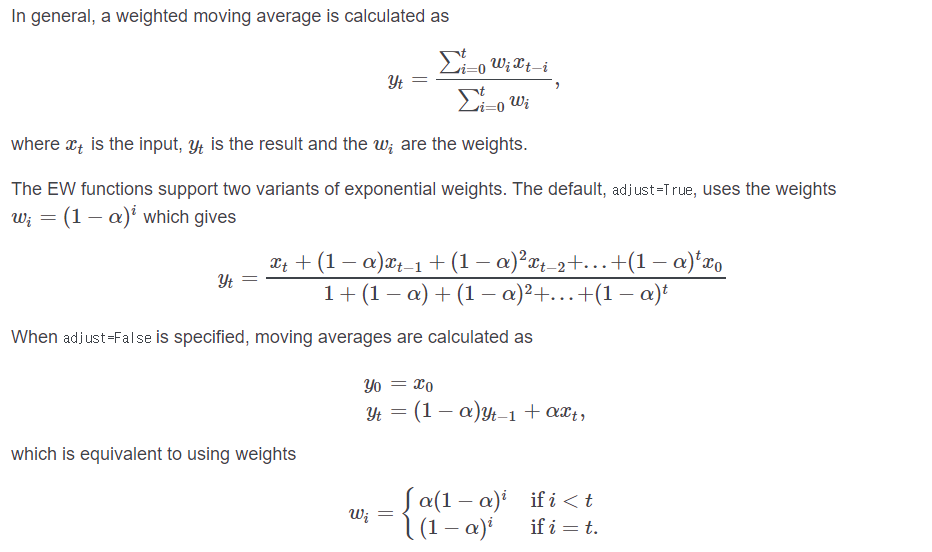

In [153]:
Image.open("ewm.png")

Text(0.5,1,'삼성전자')

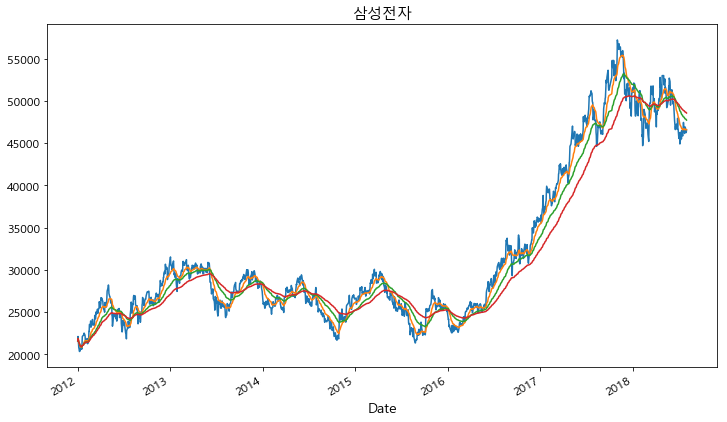

In [154]:
plt.figure(figsize=(12,7))
raw_data["005930"].Close.plot()
raw_data["005930"].Close.ewm(span=20).mean().plot()
raw_data["005930"].Close.ewm(span=60).mean().plot()
raw_data["005930"].Close.ewm(span=120).mean().plot()
plt.title("삼성전자", fontsize=15)

### Train, Test Split

In [155]:
train = {}
train_idx = {}
test = {}
test_idx = {}
for code, df in raw_data.items():
    train[code] = df.iloc[:int(len(df)*0.8)][["ma_10", "Volume", "long_short"]]
    train_idx[code] = df.iloc[:int(len(df)*0.8)]["Y"]
    test[code] = df.iloc[int(len(df)*0.8):][["ma_10", "Volume", "long_short"]]
    test_idx[code] = df.iloc[int(len(df)*0.8):]["Y"]

### Scale 조정

In [156]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
li = ["ma_10", "Volume"]
for code in raw_data.keys():
    train[code][li] = std_scaler.fit_transform(train[code][li].values)
    test[code][li] = std_scaler.fit_transform(test[code][li].values)

### model 호출

In [157]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gnb_clf = GaussianNB()
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier(random_state=42)

### Predict

In [158]:
from sklearn.metrics import accuracy_score

score_list = pd.DataFrame(columns=('GNB','KNN','RF'))

for i in raw_data.keys():
    a=[]
    X_train = train[i].values
    y_train = train_idx[i].values
    X_test = test[i].values
    y_test = test_idx[i].values
    
    for clf in (gnb_clf, knn_clf, rf_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        a.append(accuracy_score(y_test, y_pred))
    score_list.loc[i] = a

In [160]:
score_list.max()

GNB    0.706790
KNN    0.750000
RF     0.607143
dtype: float64

In [161]:
score_list.head()

,GNB,KNN,RF
006840,0.552469,0.521605,0.543210
027410,0.449275,0.632850,0.502415
282330,0.406250,0.375000,0.406250
138930,0.490741,0.530864,0.500000
001040,0.500000,0.456790,0.478395


In [162]:
score_list.loc["005930"]

GNB    0.570988
KNN    0.524691
RF     0.515432
Name: 005930, dtype: float64

### GridSearch

In [169]:
gnb_clf.get_params().keys()

dict_keys(['priors'])

In [168]:
knn_clf.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [170]:
rf_clf.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [195]:
params_rf = [
    {'n_estimators' : [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31],
    'criterion' : ["gini", "entropy"],
    'oob_score' : ["True"],
    'n_jobs' : [2]}
]
params_knn = [
    {'n_neighbors' : [1,3,5,7,9,11,15,19,25,30,35,40,45,50,60,70],
    'weights' : ["uniform", "distance"],
    'algorithm' : ["auto", "ball_tree", "kd_tree", "brute"]}
]

In [181]:
from sklearn.model_selection import GridSearchCV
rf_grid = {}
for i in raw_data.keys():
    X_train = train[i].values
    y_train = train_idx[i].values
    
    #gnb_grid_search = GridSearchCV(gnb_clf, param_grid, cv=5, n_jobs=-1)
    #gnb_grid_search.fit(X_train, y_train)

    #knn_grid_search = GridSearchCV(knn_clf, params_knn, cv=5, n_jobs=-1)
    #knn_grid_search.fit(X_train, y_train)
    
    rf_grid_search = GridSearchCV(rf_clf, params_rf, cv=5, n_jobs=-1)
    rf_grid_search.fit(X_train, y_train)
    rf_grid[i] = rf_grid_search

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

In [183]:
rf_grid["005930"].best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=2,
            oob_score='True', random_state=42, verbose=0, warm_start=False)

In [185]:
best_est_dict = {}
for i in raw_data.keys():
    best_est_dict[i] = rf_grid[i].best_estimator_

In [186]:
best_est_dict["005930"]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=2,
            oob_score='True', random_state=42, verbose=0, warm_start=False)

In [188]:
score_list.head()

,GNB,KNN,RF
006840,0.552469,0.521605,0.543210
027410,0.449275,0.632850,0.502415
282330,0.406250,0.375000,0.406250
138930,0.490741,0.530864,0.500000
001040,0.500000,0.456790,0.478395


In [193]:
score_list.at["005930", "New_RF"] = 1

In [194]:
for i in raw_data.keys():
    X_train = train[i].values
    y_train = train_idx[i].values
    X_test = test[i].values
    y_test = test_idx[i].values
    
    best_est_dict[i].fit(X_train, y_train)
    y_pred = best_est_dict[i].predict(X_test)
    score_list.at[i, "New_RF"] = accuracy_score(y_test, y_pred)

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\ensemble\forest.py:

In [199]:
score_list[score_list.columns[2:]].describe()

,RF,New_RF
count,202.000000,202.000000
mean,0.510544,0.515233
std,0.050117,0.050243
min,0.000000,0.000000
25%,0.494599,0.496914
50%,0.512346,0.515432
75%,0.533951,0.537037
max,0.607143,0.737654


In [204]:
score_list["New_RF"].argmax()

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


'042660'

In [208]:
kospi200[kospi200["종목코드"] == "042660"]

,종목코드,종목명
70,042660,대우조선해양


# Conclusion
## 평균적으로 random classifier보다 못하다.
## 알고리즘을 바꾸고 hyperparameter를 조정하기 보다
## 특성을 어떤 것을 활용할 것인지에 초점을 맞춰야 한다.